In [ ]:
import torch                        #Tensor
import torchvision                  #CNN pretrained models  
from torchvision import transforms  #Transforms during test time for input image
import torch.nn.functional as F     #supporting functions
import numpy as np                  #arrays for displaying plots
import cv2                          #Heatmap generation
import matplotlib.pyplot as plt     #displaying plots
import pickle                       #loading ImageNet classe names based on index
%matplotlib inline
from PIL import Image               #Loading images
from urllib.request import urlopen  #open URL containing ImageNet classes

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda


In [ ]:
resnet34 = torchvision.models.resnet34(pretrained = True)
#choose appropriate device
resnet34.to(device)
#set model to evaluate, this will make dropout, BN layers suitable to test time
resnet34.eval()     
print(resnet34)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [ ]:
val_transformer = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# GradCAM

# Sub Modules of GradCAM


1.   Extract target layer from our desired model
2.   Hook outputs of forward pass (activations) and backward pass (gradients)
3. Compute weighted activations
4. Upscale weighted activations to input size



One complete process to compute GradCAM:
1.   Clear gradients
2.   Forward pass input
3. Obtain required outputs nodes
4. Backward pass from desired nodes
5. Compute weights of each activation layer
6. Obtain weighted average of target_layer activations




In [ ]:
class GradCAM:
  def __init__(self, resnet34, layer_name = 'layer4_basicblock2_conv2'):
    # Save model
    self.resnet34 = resnet34
    # Clear gradients and activations
    self.activations = list()
    self.gradients = list()
    # Extract target layer
    self.target_layer = self.extract_resnet34_layer(resnet34, layer_name)
    # Hook outputs and gradients of target_layer

    #register using forward and backward hooks for the target layer
    self.target_layer.register_forward_hook(self.forward_hook)
    self.target_layer.register_backward_hook(self.backward_hook)

  def forward_hook(self, module, input, output):
      self.activations.append(output)

  def backward_hook(self, module, grad_input, grad_output):
      self.gradients.append(grad_output[0]) #grad_output is a tuple

  def forward(self, input_img):
      #1.clear gradients and hooks
      self.activations = list()
      self.gradients = list()
      self.resnet34.zero_grad()
      #2. forward pass
      out = self.resnet34(torch_img)
      #3. Obtain desired output node
      out = out.squeeze()
      out_sort, out_perm = out.sort()
      out_max = out_sort[-1]
      #4. backward pass
      out_max.backward()
      #5. Compute weighted activations
      gradcam = self.compute_weighted_act()
      return gradcam, out_perm[-1] #out_perm[-1]: class of max

  def compute_weighted_act(self):
      """
      Computing grad cam as weighted average of activations of output layer.
      Weights is mean of gradients.
      """
      # Computation of grad mean
      grads = self.gradients[0].squeeze()
      grads = grads.mean(dim=[1,2], keepdim=True)
      # Activations
      acts = self.activations[0]
      acts = acts.squeeze()
      # Weighted activations
      wtd_act = F.relu(grads*acts)
      wtd_act = wtd_act.sum(axis = 0, keepdim = True).unsqueeze(dim=0) #unsqueeze is for upsampling
      wtd_act = wtd_act.detach().cpu()
      wtd_min, wtd_max = wtd_act.min(), wtd_act.max()
      wtd_normalised = (wtd_act - wtd_min)/(wtd_max - wtd_min)
      # Upsample activations to input size
      wtd_upsampled = F.upsample(wtd_normalised, size=(224,224), mode='bicubic')
      return wtd_upsampled
  
  def extract_resnet34_layer(self, model, layer_name):
    """
    currently implementing it for resnet 34
    """
    if 'layer' in layer_name :
      hierarchy = layer_name.split('_')
      index = int(hierarchy[0].lower().lstrip('layer'))
      if index == 1:
        target_layer = model.layer1
      elif index == 2:
        target_layer = model.layer2
      elif index == 3:
        target_layer = model.layer3
      elif index == 4:
        target_layer = model.layer4
      else:
        raise ValueError(f"Unknown layer_name: {layer_name}")

      if 'basicblock' in layer_name:
        index = int(hierarchy[1].lower().lstrip('basicblock'))
        target_layer = target_layer[index] #_modules() is used to extract layers of a sequential block

      if 'conv' in layer_name:
        index = hierarchy[2].lower()
        target_layer = target_layer._modules['conv2']
      return target_layer
  
  def visualise_heatmap(self, input_img, gradcam_out, alpha=1.0):
     gradcam_in = (255 * gradcam_out.squeeze()).type(torch.uint8).cpu().numpy()
     heatmap = cv2.applyColorMap(gradcam_in, cv2.COLORMAP_JET)
     heatmap = torch.from_numpy(heatmap).permute(2,0,1).float().true_divide(255)
     b, g, r = heatmap.split(1)
     heatmap = torch.cat([r, g, b])
     result = heatmap*alpha + input_img.squeeze().to('cpu')
     result = result.detach()
     result = result.true_divide(result.max())
     heatmap = heatmap.detach()
     return heatmap, result

# One Example of GradCAM Computation

Obtain input image and apply test transformation on input image

Text(0.5, 1.0, 'Input Image')

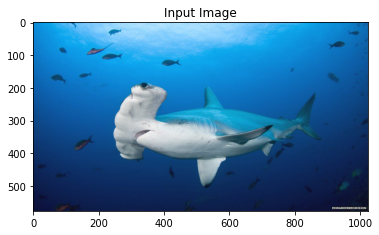

In [ ]:
img_path = '/content/drive/My Drive/PyTorch Practice/images/1.jpg'
sample_img = Image.open(img_path).convert('RGB')
torch_img = val_transformer(sample_img)
torch_img = torch_img.to(device)
torch_img.unsqueeze_(dim=0)

plt.figure()
plt.imshow(sample_img)
plt.title('Input Image')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


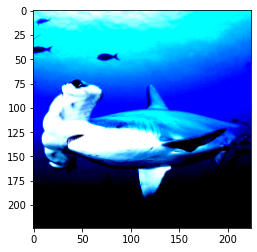

In [ ]:
plt.imshow(torch_img.detach().cpu().squeeze().permute(1,2,0).numpy())

Initialise GradCAM and compute output for input image

In [ ]:
grad_cam = GradCAM(resnet34)
gradcam_out, out_class = grad_cam.forward(torch_img)
heatmap, result = grad_cam.visualise_heatmap(torch_img, gradcam_out,4)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


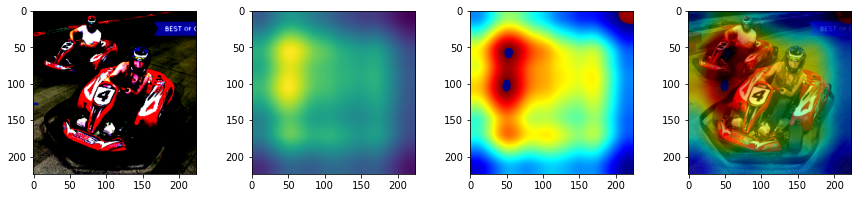

In [ ]:
fig = plt.figure(figsize=(15,3))
ax = fig.subplots(1,4)
ax[0].imshow(torch_img.detach().cpu().squeeze().permute(1,2,0).numpy())
ax[1].imshow(gradcam_out.detach().cpu().squeeze().numpy())
ax[2].imshow(heatmap.permute(1,2,0).numpy())
ax[3].imshow(result.permute(1,2,0).numpy())

Predictions over a set of images


In [ ]:
classes = pickle.load(urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl'))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


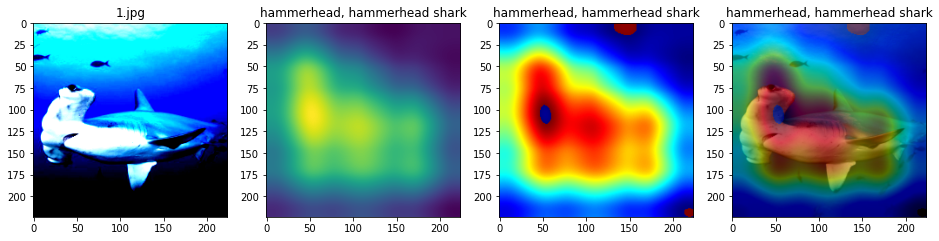

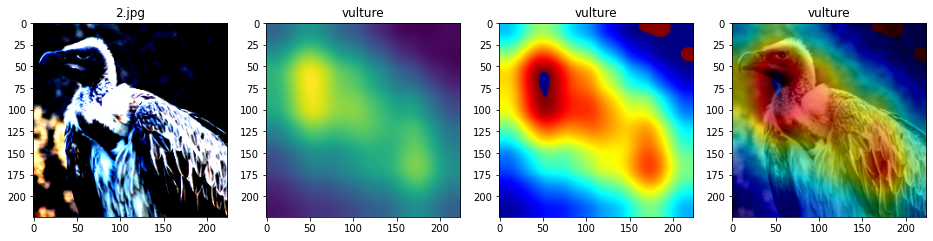

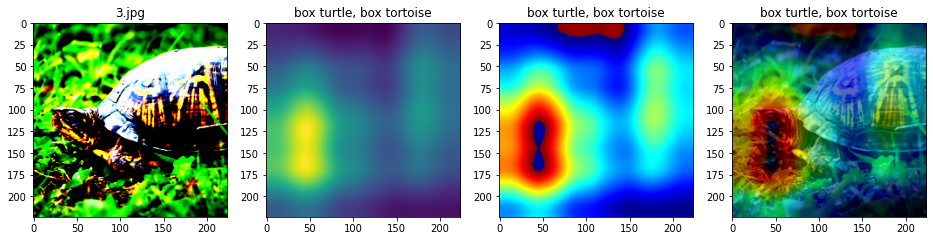

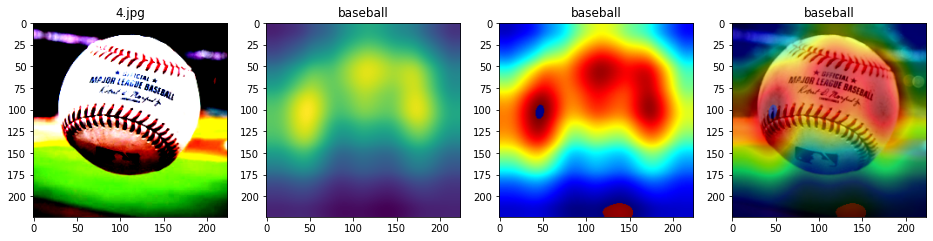

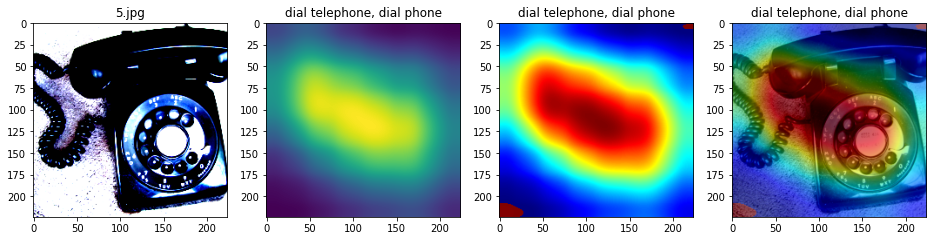

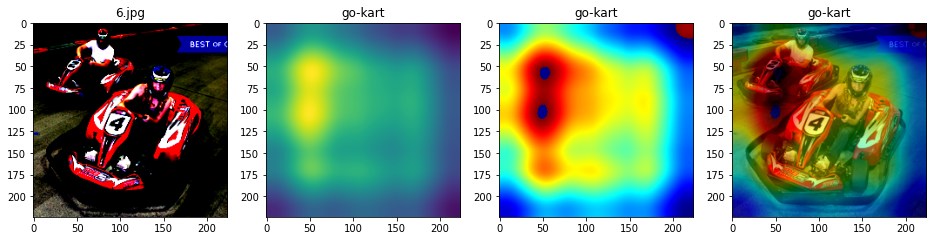

In [ ]:
for i in range(1,7):
  #input image
  img_path =  '/content/drive/My Drive/PyTorch Practice/images/' + str(i) + '.jpg'
  sample_img = Image.open(img_path).convert('RGB')
  torch_img = val_transformer(sample_img)
  torch_img = torch_img.to(device)
  torch_img.unsqueeze_(dim=0)

  #gradcam
  gradcam_out, out_class = grad_cam.forward(torch_img)
  heatmap, result = grad_cam.visualise_heatmap(torch_img, gradcam_out, 4)
  out_class = out_class.detach().cpu().item()

  #display results
  fig = plt.figure(figsize=(16,4))
  ax = fig.subplots(1,4)
  ax[0].imshow(torch_img.detach().cpu().squeeze().permute(1,2,0).numpy())
  ax[0].set_title(str(i) + '.jpg')
  ax[1].imshow(gradcam_out.detach().cpu().squeeze().numpy())
  ax[1].set_title(classes[out_class])
  ax[2].imshow(heatmap.permute(1,2,0).numpy())
  ax[2].set_title(classes[out_class])
  ax[3].imshow(result.permute(1,2,0).numpy())
  ax[3].set_title(classes[out_class])
  print("=============================================")